# <a id='toc1_'></a>[Прогнозирование повторных покупок клиентов интернет-магазина](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Прогнозирование повторных покупок клиентов интернет-магазина](#toc1_)    
  - [Импорт Библиотек](#toc1_1_)    
  - [Импорт Датасетов](#toc1_2_)    
  - [Изучение и подготовка массива apparel_purchases](#toc1_3_)    
    - [Создание агрегированного набора](#toc1_3_1_)    
    - [Преобразование category_ids](#toc1_3_2_)    
  - [Кластеризация рассылок по массиву full_campaign_daily_event](#toc1_4_)    
  - [Изучение и подготовка apparel_messages](#toc1_5_)    
  - [Подготовка итогового датасета](#toc1_6_)    
    - [Исследование взаимосвязей](#toc1_6_1_)    
  - [Моделирование](#toc1_7_)    
    - [Показатели модели на Train](#toc1_7_1_)    
    - [Показатели модели на Validation](#toc1_7_2_)    
    - [Показатели модели на Test](#toc1_7_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Импорт Библиотек](#toc0_)

In [163]:
from ast import literal_eval


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from scipy.stats import uniform, randint, loguniform


from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


import optuna


from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, 
    roc_curve
)


import phik
from phik import report


## <a id='toc1_2_'></a>[Импорт Датасетов](#toc0_)

In [164]:
apparel_purchases = pd.read_csv("filtered_data/apparel-purchases.csv")

apparel_messages = pd.read_csv("filtered_data/apparel-messages.csv")

target = pd.read_csv("filtered_data/apparel-target_binary.csv")

full_campaign_daily_event = pd.read_csv("filtered_data/full_campaign_daily_event.csv")

full_campaign_daily_event_channel = pd.read_csv("filtered_data/full_campaign_daily_event_channel.csv")

## <a id='toc1_3_'></a>[Изучение и подготовка массива apparel_purchases](#toc0_)

In [165]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Всего 6 столбцов. Из них 2 - это идентификаторы. 

In [166]:
apparel_purchases["client_id"].nunique()

49849

In [167]:
len(target)

49849

Всего 49849 Уникальных id. Это совпадает с количеством строк в таргете

In [168]:
apparel_purchases.duplicated().sum()

73020

Есть 73020 дубликатов. Однако мы не можем быть уверены: это настоящие дубликаты или повторяющиеся покупки одного товара


In [169]:
apparel_purchases["quantity"].value_counts()


quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Видим, что абсолютно большинство записей указывают на покупку одной единицы товара. 

Будем исходить из того, что единовременная покупка более одной единицы попадает в базу отдельными рядами. К сожалению, остается непроясненным остается, в каких условиях все же будет логироваться более одной единицы

Дубликаты сохраняем в датасете

In [170]:
apparel_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Пропущенных значений нет

In [171]:
apparel_purchases["price"].describe()


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

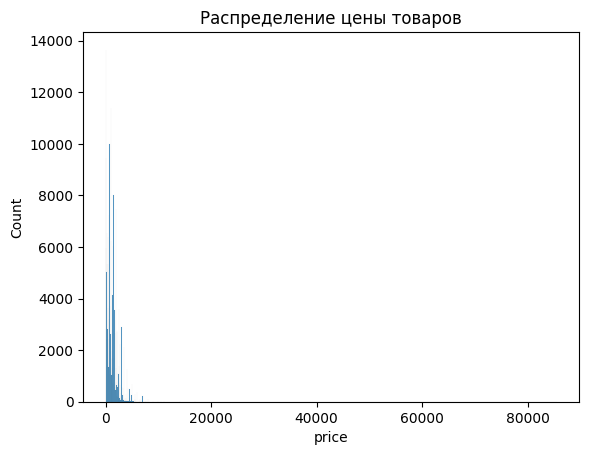

In [172]:
sns.histplot(data = apparel_purchases, x = "price")
plt.title("Распределение цены товаров")
plt.show()

Болшая часть наблюдений находится в промежутке между 352 и 1699. 
Однако распределение очень сильно скошено вправо, из-за редких покупок чья цена заметно выше, чем цена остальных товаров

In [173]:
apparel_purchases["message_id"].nunique()


50204

50204 уникальных значений. 
Каждый пользователь мог получать более одной рассылки

### <a id='toc1_3_1_'></a>[Создание агрегированного набора](#toc0_)

In [174]:
result = apparel_purchases.groupby("client_id").agg(
    total_quantity = ('quantity', 'sum'),
    mean_price=('price', 'mean'),
    total_spent=('price', 'sum'),
    unique_dates=('date', 'nunique'),
    latest_date=('date', 'max'),
    first_date = ('date', 'min'))



apparel_purchases_agg = pd.DataFrame(result)

In [175]:
apparel_purchases_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_quantity  49849 non-null  int64  
 1   mean_price      49849 non-null  float64
 2   total_spent     49849 non-null  float64
 3   unique_dates    49849 non-null  int64  
 4   latest_date     49849 non-null  object 
 5   first_date      49849 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 2.7+ MB


Создаем следующие аггрегированные переменные

`total_quantity` - сколько всего единиц товара купил клиент

`mean_price` - средняя цена одной покупки

`total_spent` - сумма всех потраченных средств

`unique_dates` - количество уникальных дней, в которые были совершены покупки

`latest_date` - самая поздняя дата покупки

`first_date` - самая ранняя дата покупки

In [176]:
date_columns = ['latest_date', 'first_date']
apparel_purchases_agg[date_columns] = apparel_purchases_agg[date_columns].apply(pd.to_datetime)


overall_latest_date = pd.to_datetime(apparel_purchases['date']).max() # вычисляем самую позднюю дату в датасете
overall_first_date = pd.to_datetime(apparel_purchases['date']).min()  # вычисляем самую ранню дату в датасете


apparel_purchases_agg = apparel_purchases_agg.assign(
    days_since_last_purchase=(overall_latest_date - apparel_purchases_agg['latest_date']).dt.days,
    customer_lifetime=(apparel_purchases_agg['latest_date'] - apparel_purchases_agg['first_date']).dt.days
)

Создаем два признака. 

`days_since_last_purchase` - Сколько дней прошло с последней покупки и 

`customer_lifetime` - сколько дней прошло между первой и последней покупкой.

Были попытки еще создать другие признаки, но они не внесли вклада в модель.

### <a id='toc1_3_2_'></a>[Преобразование category_ids](#toc0_)

In [177]:
grouped_data = apparel_purchases.groupby('client_id')

In [178]:
# Создаем пустой список, который будет хранить агрегированные категории для каждого client_id
aggregated_categories = []



for client_id, group in grouped_data:
    all_items = [] # Создаем пустой список для хранения всех категорий текущего клиента
    for sublist in group['category_ids']: # Проходим по каждому значению в колонке 'category_ids' для текущего клиента
        if sublist is not None:  # Проверяем на None
            sublist = eval(sublist) # Преобразуем строку в Python-объект
            all_items.extend([x for x in sublist if x is not None])  # Добавляем все элементы из подсписка в общий список, игнорируя None
    aggregated_categories.append(sorted(list(set(all_items)))) #убираем дубликаты, через преобразование в множество, конвертируем обратном в список и сортируем

In [179]:
# Промежуточный датафрейм, где у каждого клиента список категорий товаров, в которых он покупал
result_df = pd.DataFrame({
    'client_id': grouped_data.groups.keys(),
    'category_ids': aggregated_categories
})

In [180]:
# Преобразуем списки в набор бинарных переменных
one_hot = pd.get_dummies(result_df['category_ids'].explode(), prefix='category')


In [181]:
# Агреггируем, так чтобы для каждого клиента осталась одна строка
one_hot = one_hot.groupby(level=0).max()

In [182]:
# Возвращаем столбец client_id

result_one_hot = pd.concat([result_df[['client_id']], one_hot], axis=1)


In [183]:
# Преобразуем в числовой формат из bool 

numeric_columns = [col for col in result_one_hot.columns if col != 'client_id']
result_one_hot = result_one_hot.astype({col: 'int8' for col in numeric_columns})

In [184]:
# Отбираем столбцы, частота которых в данных больше 2%
category_columns = result_one_hot.filter(like='category_').columns
column_percentages = result_one_hot[category_columns].mean()
columns_to_keep = column_percentages[column_percentages > 0.02].index
category_df = result_one_hot[['client_id'] + list(columns_to_keep)]

In [185]:
# Присоединяем бинарные значения покупки товаров к агрегированному датасету
apparel_purchases_agg = apparel_purchases_agg.merge(category_df, on="client_id", how = "left")


In [186]:
apparel_purchases_agg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_quantity            49849 non-null  int64         
 2   mean_price                49849 non-null  float64       
 3   total_spent               49849 non-null  float64       
 4   unique_dates              49849 non-null  int64         
 5   latest_date               49849 non-null  datetime64[ns]
 6   first_date                49849 non-null  datetime64[ns]
 7   days_since_last_purchase  49849 non-null  int64         
 8   customer_lifetime         49849 non-null  int64         
 9   category_124              49849 non-null  int8          
 10  category_146              49849 non-null  int8          
 11  category_17               49849 non-null  int8          
 12  category_18       

Подгтовлен датасет, в которым мы агрегировали информацию о покупках пользователей.

## <a id='toc1_4_'></a>[Кластеризация рассылок по массиву full_campaign_daily_event](#toc0_)

Идея последующего анализа в том, что полученные пользователем рассылки могли повлиять на его решение о покупке, даже если они не привели к зафиксированному действию исходя из рассылки. Например, пользователь мог открыть рассылку, но не пройти по ссылке в ней, а отдельно зайти на сайт и купить товар

Либо наоборот, он получил рассылку, которая вызвала негативное отношение, не не отписался от рассылки. Тем не менее, это могло повлиять на его решение покупать товар.

Поскольку индивидуальных рассылок слишком много, мы попробовали кластеризовать их

In [187]:
# Агрегируем количество зафиксированных действия пользователей по каждой рассылки


full_campaign_agg = full_campaign_daily_event.groupby("bulk_campaign_id").agg(
    campaign_duration = ('date', 'nunique'),
    campaign_send = ("count_send", "sum"),
    campaign_clicks = ("count_click", "sum"),
    campaign_complain = ("count_complain", "sum"),
    campaign_hard_bounce = ("count_hard_bounce", "sum"),
    campaign_open = ("count_open", "sum"),
    campaign_purchase = ("count_purchase", "sum"),
    campaign_soft_bounce = ("count_soft_bounce", "sum"),
    campaign_subscribe = ("count_subscribe", "sum"),
    campaign_unsubscribe = ("count_unsubscribe", "sum")
)


# Нормируем количество действий на длительность кампании в днях
columns_to_normalize = ["campaign_clicks", "campaign_complain", 
                       "campaign_open", "campaign_purchase",  
                        "campaign_unsubscribe"]
norming_column = "campaign_duration"

for column in columns_to_normalize:
    full_campaign_agg[column] = full_campaign_agg[column] / full_campaign_agg[norming_column]

full_campaign_agg = full_campaign_agg.reset_index()

In [188]:

scaler = StandardScaler()

# Отбираем признаки для кластеризации
clustering_features = ["campaign_clicks", "campaign_complain", 
                       "campaign_open", "campaign_purchase",  
                        "campaign_unsubscribe"]
full_campaign_agg_cluster_data = full_campaign_agg[clustering_features]

# Масштабируем признаки
scaled_data = scaler.fit_transform(full_campaign_agg_cluster_data)

# Фиксируем количество кластеров
N_CLUST = 10

# Выполняем кластеризацию
kmeans = KMeans(n_clusters=N_CLUST, random_state=42)
kmeans.fit(scaled_data)

# Добавляем метки кластеров
full_campaign_agg['cluster'] = kmeans.labels_

# Создаем бинарную переменную о принадлежности к кластеру
for i in range(N_CLUST):
   full_campaign_agg[f'cluster_{i+1}'] = (full_campaign_agg['cluster'] == i).astype(int)



In [189]:
full_campaign_agg['cluster'].value_counts()

cluster
1    2683
0     214
8      89
6      85
9      32
5      29
3      28
4      16
7       4
2       1
Name: count, dtype: int64

Кластеризация вышла скорее неудачная. Большая часть рассылок ушли в один единственный кластер. 
В распределении признаков есть какое количество аутлайеров, которые "разбрелились" по оставшимся кластерам
Однако в дальнейшем при построении модели, принадлежность к кластерам оказалась полезной, поэтому было принято решение оставить их в модели

## <a id='toc1_5_'></a>[Изучение и подготовка apparel_messages](#toc0_)

In [190]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [191]:
apparel_messages["bulk_campaign_id"].nunique()

2709

Всего было 2709 уникальных рассылки. Вероятность возвращения клиента может зависеть от "качества" рассылки, поэтому мы попытались учесть этот параметр за счет кластеризации, выполненной выше 

In [192]:
apparel_messages["client_id"].nunique()

53329

В этом датасете больше клиентов, чем в датасете с покупками

In [ ]:
# Преобразуем столбцы client_id в множества
messages_clients = set(apparel_messages['client_id'])
purchases_clients = set(apparel_purchases['client_id'])

# Находим общие значения (пересечение множеств)
common_clients = messages_clients.intersection(purchases_clients)

# Находим уникальные значения для каждого датасета
only_messages = messages_clients - purchases_clients
only_purchases = purchases_clients - messages_clients

# Выводим результаты
print(f"Общих client_id: {len(common_clients)}")
print(f"Уникальных client_id только в messages: {len(only_messages)}")
print(f"Уникальных client_id только в purchases: {len(only_purchases)}")

Количество уникальных клиентов отличается от датасета с покупками и таргетом. 
Таких пользователей мы уберем при слиянии датасетов. 
Помимо этого есть пользователи, которые могли делать покупки, но у нас нет данных о получаемых ими рассылках. Таких пользователей мы в анализе сохраним и присвоим ими нули в признаках, связанных с рассылками

In [193]:
apparel_messages["event"].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

Видим, что по обобщенным данным логичная воронка. 

Количество значений снижается от общего события (отправка писем) к последующим частным событиям (открытое письмо, клик на письмо и покупка). 

Также часто встречаются ошибки отправки. В данном случае нужно понять, может ли пользователь вообще "вернуться" и войти на сайт, если его почта не работает

Наиболее редки негативные события - отписка от рассылка, перемещение в спам. Однако они, вероятно, будут хорошо предсказывать отказ клиента от дальнейших покупок

In [194]:
apparel_messages["channel"].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

Используются два канала - mobile_push и email. 

mobile_push чаще


In [195]:
(apparel_messages.groupby("channel")["event"].value_counts(normalize=True) * 100).round(2)


channel      event      
email        send           75.32
             open           16.73
             click           6.81
             purchase        0.87
             soft_bounce     0.18
             unsubscribe     0.05
             hbq_spam        0.02
             complain        0.01
             hard_bounce     0.01
             subscribe       0.00
mobile_push  send           68.17
             open           29.43
             click           1.86
             hard_bounce     0.26
             purchase        0.26
             soft_bounce     0.01
             close           0.00
Name: proportion, dtype: float64

Открывают чаще мобильные пуши, но до покупок чаще доходят именно почтовые рассылки

In [196]:
apparel_messages["date"].head()

0    2022-05-19
1    2022-05-19
2    2022-05-19
3    2022-05-19
4    2022-05-19
Name: date, dtype: object

In [197]:
apparel_messages["created_at"].head()

0    2022-05-19 00:14:20
1    2022-05-19 00:39:34
2    2022-05-19 00:51:49
3    2022-05-19 00:52:20
4    2022-05-19 00:56:52
Name: created_at, dtype: object

Для рассылок есть полное время. Это позволит выявить "полные дубликаты"

In [198]:
apparel_messages.duplicated().sum()

48610

Есть 48610 полных дубликатов. Удаляем их.
В реальности нужно было бы уточнить их природу - это ошибка логов, или ошибка рассылки (пользователь действительно получал дважды одинаковое сообщение?)

In [199]:
apparel_messages = apparel_messages.drop_duplicates(keep='first')


In [200]:
# Добавляем информацию о кластере каждой рассылки
apparel_messages = apparel_messages.merge(full_campaign_agg, on = "bulk_campaign_id", how = "left" )

In [201]:
# Создаем агрегированный датафрейм
apparel_messages_agg = apparel_messages.groupby("client_id").agg(
    click_count=('event', lambda x: (x == 'click').sum()),
    purchase_count=('event', lambda x: (x == 'purchase').sum()),
    send_count=('event', lambda x: (x == 'send').sum()),
    open_count=('event', lambda x: (x == 'open').sum()),
    hard_bounce_count=('event', lambda x: (x == 'hard_bounce').sum()),
    unsubscribe_count=('event', lambda x: (x == 'unsubscribe').sum()),
    complain_count=('event', lambda x: (x == 'complain').sum()),
    subscribe_count=('event', lambda x: (x == 'subscribe').sum()),
    email_count=('channel', lambda x: (x == 'email').sum()),
    mobile_push_count=('channel', lambda x: (x == 'mobile_push').sum()),
    in_cluster_1=('cluster_1', 'max'),
    in_cluster_2=('cluster_2', 'max'),
    in_cluster_3=('cluster_3', 'max'),
    in_cluster_4=('cluster_4', 'max'),
    in_cluster_5=('cluster_5', 'max'),
    in_cluster_6=('cluster_6', 'max'),
    in_cluster_7=('cluster_7', 'max'),
    in_cluster_8=('cluster_8', 'max'),
    in_cluster_9=('cluster_9', 'max'),
    in_cluster_10=('cluster_10', 'max')
)


apparel_messages_agg = pd.DataFrame(apparel_messages_agg)

In [203]:
apparel_messages_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   click_count        53329 non-null  int64
 1   purchase_count     53329 non-null  int64
 2   send_count         53329 non-null  int64
 3   open_count         53329 non-null  int64
 4   hard_bounce_count  53329 non-null  int64
 5   unsubscribe_count  53329 non-null  int64
 6   complain_count     53329 non-null  int64
 7   subscribe_count    53329 non-null  int64
 8   email_count        53329 non-null  int64
 9   mobile_push_count  53329 non-null  int64
 10  in_cluster_1       53329 non-null  int32
 11  in_cluster_2       53329 non-null  int32
 12  in_cluster_3       53329 non-null  int32
 13  in_cluster_4       53329 non-null  int32
 14  in_cluster_5       53329 non-null  int32
 15  in_cluster_6       53329 non-null  int32
 16  in_cluster_7       53329 non-nu

В результате получили агрегированный датасет, в котором есть сумма действий пользователи в ответ на каждую рассылку (количество открытий, кликов, покупок и т.д.), информация о том, сколько всего рассылок получал пользователей, а также информация о том, к каким кластерам принадлежит полученная им рассылка

## <a id='toc1_6_'></a>[Подготовка итогового датасета](#toc0_)

In [204]:
# Создаем финальный датасет, объединяя аггеригоррванную информацию о покупках, рассылка и таргет

final_df = apparel_purchases_agg.merge(apparel_messages_agg, on = "client_id", how = "left").merge(target, on="client_id")

In [205]:
missing_counts = final_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

click_count          7867
purchase_count       7867
send_count           7867
open_count           7867
hard_bounce_count    7867
unsubscribe_count    7867
complain_count       7867
subscribe_count      7867
email_count          7867
mobile_push_count    7867
in_cluster_1         7867
in_cluster_2         7867
in_cluster_3         7867
in_cluster_4         7867
in_cluster_5         7867
in_cluster_6         7867
in_cluster_7         7867
in_cluster_8         7867
in_cluster_9         7867
in_cluster_10        7867
dtype: int64

Как и ожидалось, в финальном массиве есть пропуски, связанны с тем, что не обо всех клиентах есть информация о полученных ими рассылках
В данном случае логично приравнять отсутствие такой информации к нулю

In [206]:
final_df = final_df.fillna(0)

### <a id='toc1_6_1_'></a>[Исследование взаимосвязей](#toc0_)

In [ ]:
columns_to_check = [col for col in final_df.columns if col not in ['client_id', 'target']]
phik_coefficients = {}

# Собираем коэффициенты для каждой колонки
for column in columns_to_check:
    try:
        result = phik.phik_matrix(final_df[[column, "target"]])
        # Если матрица неполная, считаем корреляцию нулевой
        if result.shape != (2, 2):
            phik_coefficients[column] = 0.0
        else:
            phik_coefficients[column] = result.values[0,1]
    except Exception as e:
        print(f"Warning: Error processing {column}, setting correlation to 0")
        phik_coefficients[column] = 0.0

# Создаем DataFrame
phik_df = pd.DataFrame.from_dict(phik_coefficients, orient='index', columns=['phik_coefficient'])
phik_df = phik_df.sort_values('phik_coefficient', ascending=False)



In [208]:
print("\nTop 10 features by Phik correlation:")
print(phik_df.head(20))


Top 10 features by Phik correlation:
                          phik_coefficient
latest_date                       0.163991
customer_lifetime                 0.134146
first_date                        0.123334
days_since_last_purchase          0.115966
unique_dates                      0.074335
click_count                       0.070769
purchase_count                    0.069807
mobile_push_count                 0.064416
open_count                        0.057812
send_count                        0.056721
total_quantity                    0.049839
category_27                       0.046442
category_436                      0.045507
in_cluster_1                      0.043173
in_cluster_6                      0.041834
category_6060                     0.039587
category_213                      0.039547
in_cluster_7                      0.039517
total_spent                       0.034520
category_62                       0.034195


Видим, что больше всего связан с вероятностью покупки такие переменные как

`customer_lifetime`

`days_since_last_purchase`

`unique_dates`

`click_count`

`purchase_count`

`purchase_amount`

`Mobile_push_count`

`open_count`


Важно, что связь с таргетом имеют также и отдельные категории товаров и даже принадлежность к кластерам рассылок

Помимо этого - самостоятельное значение имеют даты, как категориальные признаки. Однако мы их исключим из анализа, поскольку посредством этих данных были созданые другие признаки. 

In [209]:
final_df["target"].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

В данных большой дисбаланс. Надо это учесть при моделировании

## <a id='toc1_7_'></a>[Моделирование](#toc0_)

In [210]:
# Исключем таргет, id и информацию о датах из признаков
X = final_df.drop(["target", "client_id", 'latest_date', 'first_date'], axis = 1)
y = final_df["target"]

In [211]:
# Создаем train, val, test дизайн


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,            
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,       
    random_state=42
)

В ходе исследования попытки использования инструментов для дисбаланса классов, такие как андерсемплинг и оверсемплинг классов себя не очень хорошо показали. Поскольку лучшей моделью кросс-валидации был выбран catboost, который имеет собственный инструмент балансировки классов, здесь мы эту проблему не решает

In [212]:
# У нас нет в датасете категориальных колонок, Все категориальные признаки были закодированы в бинарный численный формат на этапе подготовки массива. 
# однако оставим эту функцию на случай если они появятся
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


num_cols = ["total_quantity", "mean_price", "total_spent",
"unique_dates", "days_since_last_purchase", "customer_lifetime", "click_count",
"purchase_count", "send_count", "open_count", "hard_bounce_count", "unsubscribe_count",
"complain_count", "subscribe_count", "email_count", "mobile_push_count"]

Изначально отбор модели происходил через optuna. Оставляя код, но в дальнейшем использую уже полученные параметры для лучшей модели

```
def create_pipeline(trial, classifier_name):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=trial.suggest_categorical('num_imputer_strategy', ['mean', 'median']))),
        ('scaler', StandardScaler())
    ])
    
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ], remainder='passthrough')
    
    if classifier_name == 'logistic':
        classifier = LogisticRegression(
            C=trial.suggest_float('lr_C', 1e-3, 10, log=True),
            max_iter=trial.suggest_int('lr_max_iter', 100, 500),
            random_state=42
        )
    elif classifier_name == 'decision_tree':
        classifier = DecisionTreeClassifier(
            max_depth=trial.suggest_int('dt_max_depth', 3, 15),
            min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('dt_min_samples_leaf', 1, 10),
            random_state=42
        )
    elif classifier_name == 'lgbm':
        classifier = LGBMClassifier(
            n_estimators=trial.suggest_int('lgbm_n_estimators', 50, 300),
            learning_rate=trial.suggest_float('lgbm_learning_rate', 0.01, 0.3, log=True),
            num_leaves=trial.suggest_int('lgbm_num_leaves', 15, 127),
            min_child_samples=trial.suggest_int('lgbm_min_child_samples', 5, 100),
            subsample=trial.suggest_float('lgbm_subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('lgbm_colsample_bytree', 0.5, 1.0),
            random_state=42
        )
    elif classifier_name == 'catboost':
        classifier = CatBoostClassifier(
            iterations=trial.suggest_int('cb_iterations', 50, 500),
            learning_rate=trial.suggest_float('cb_learning_rate', 0.001, 0.1, log=True),
            depth=trial.suggest_int('cb_depth', 3, 12),
            l2_leaf_reg=trial.suggest_float('cb_l2_leaf_reg', 1, 30),
            random_strength=trial.suggest_float('cb_random_strength', 1e-3, 20, log=True),
            min_data_in_leaf=trial.suggest_int('cb_min_data_in_leaf', 1, 50),
            auto_class_weights=trial.suggest_categorical('cb_class_weights', [None, 'Balanced', 'SqrtBalanced']),
            subsample=trial.suggest_float('cb_subsample', 
            0.5, 1.0),  # Добавил для баггинга
            leaf_estimation_iterations=trial.suggest_int('cb_leaf_estimation_iterations', 
            1, 10),  # Добавил для точности оценки листьев
            random_state=42,
            verbose=False
        )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

def objective(trial, X, y, classifier_name):
    pipeline = create_pipeline(trial, classifier_name)
    
    scores = cross_val_score(
        pipeline, X, y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    return scores.mean()

classifiers = ['logistic', 'decision_tree', 'lgbm', 'catboost']
studies = {}

for classifier in classifiers:
    study = optuna.create_study(
        direction='maximize',
        study_name=f'{classifier}_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize each classifier
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, classifier),
        n_trials=50,  # Adjust based on your computational budget
        n_jobs=1,  # Use 1 for CatBoost, -1 for others
        show_progress_bar=True
    )
    
    studies[classifier] = study

# Get best results for each classifier
best_results = {}
for classifier, study in studies.items():
    best_results[classifier] = {
        'best_score': study.best_value,
        'best_params': study.best_params
    }
    print(f"\nBest {classifier} Results:")
    print(f"Score: {study.best_value:.4f}")
    print("Parameters:", study.best_params)

best_classifier = max(best_results.items(), key=lambda x: x[1]['best_score'])[0]

final_pipeline = create_pipeline(
    optuna.trial.FixedTrial(best_results[best_classifier]['best_params']),
    best_classifier
)

```

In [213]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# Создаем CatBoost с оптимальными параметрами полученными через Optuna
catboost_classifier = CatBoostClassifier(
    iterations=308,
    learning_rate=0.030595276962024773,
    depth=3,
    l2_leaf_reg=6.394738594560913,
    random_strength=0.9803777223919052,
    min_data_in_leaf=38,
    auto_class_weights='SqrtBalanced',
    subsample=0.6594952902213623,
    leaf_estimation_iterations=8,
    random_state=42,
    verbose=False
)

# Создаем финальный пайплайн
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', catboost_classifier)
])

In [214]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_quantity',
                                                   'mean_price', 'total_spent',
                                                   'unique_dates',
                                                   'days_since_last_purchase',
                                                   'customer_lifetime',
                                                   'click_count',
                                                   'purchase_count',
                                                   'send_count', 'open_count',
                                                   'hard_bounce_count',
                                                   'unsubscribe_count',
                                                   'complain_count',
                                                   'subscribe_count',
                                                   'email_count',
                                                   'mobile_push_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001FF05EEB8D0>)])

###  Feature Importance

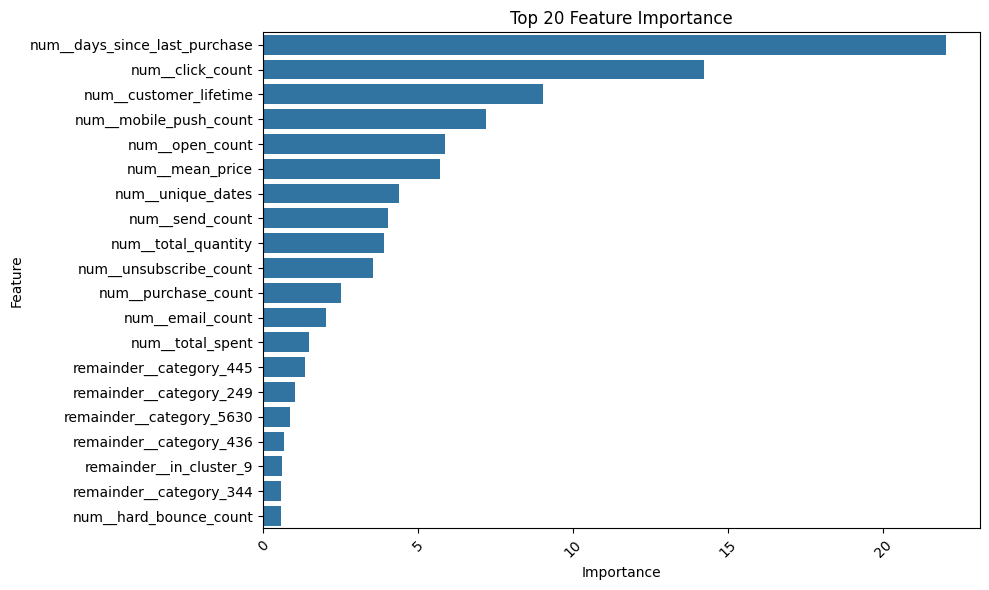

In [215]:
# Получаем модель CatBoost из пайплайна
catboost_model = final_pipeline.named_steps['classifier']

# Получение Feature Importance 
feature_importance = catboost_model.get_feature_importance()
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Создаем датафрейм с важностью признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### <a id='toc1_7_1_'></a>[Показатели модели на Train](#toc0_)

In [216]:
y_pred = final_pipeline.predict(X_train)
y_proba = final_pipeline.predict_proba(X_train)
y_proba_positive = final_pipeline.predict_proba(X_train)[:, 1]

probs_df = pd.DataFrame({
    'true_label': y_train,
    'predicted_prob': y_proba_positive
})






AUC Score: 0.777

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29332
           1       0.30      0.09      0.14       577

    accuracy                           0.98     29909
   macro avg       0.64      0.54      0.57     29909
weighted avg       0.97      0.98      0.97     29909



<Figure size 1000x800 with 0 Axes>

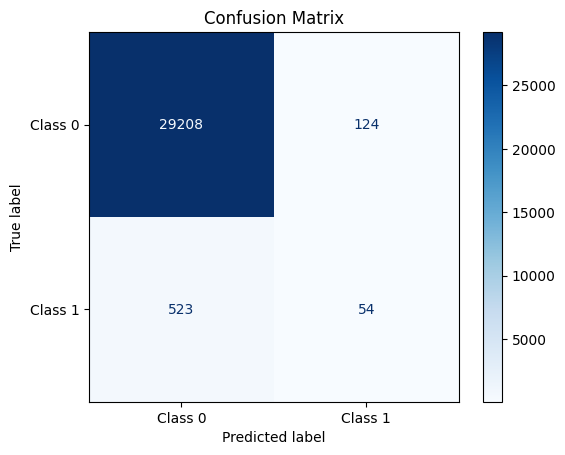

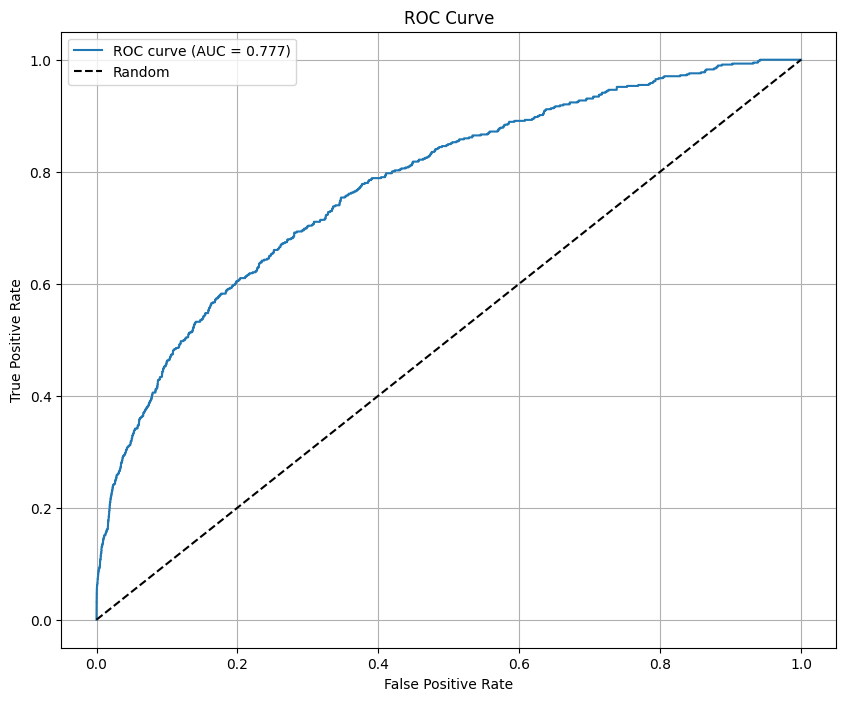

In [217]:

auc_score = roc_auc_score(y_train, y_proba_positive)
conf_matrix = confusion_matrix(y_train, y_pred)


print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_train, y_pred))


plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)


plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_train, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

На Train модель показывает результат 0.77
Это позволяет сказать, что модель предсказывает вероятность того, что клиент совершит покупки заметно лучше, чем случайная догадка.

В то же время, confusion матрица показывает, что точность модели возникает в первую очередь за счет того. что она хорошо различает тех клиентов, которые не вернутся за покупками. В отношении этого класса у модели высок как precision, так и recall

Заметно хуже дела обстоят с предсказанием клиентов, которые совершает покупку.

При пороге классификации по умолчанию модель не смогла распознать абсолютное большинство покупателей. На каждого десятого "пропущенного" покупателя приходится только 1 верно угаданный. 



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     29332
           1       0.08      0.46      0.14       577

    accuracy                           0.89     29909
   macro avg       0.54      0.68      0.54     29909
weighted avg       0.97      0.89      0.93     29909



<Figure size 1000x800 with 0 Axes>

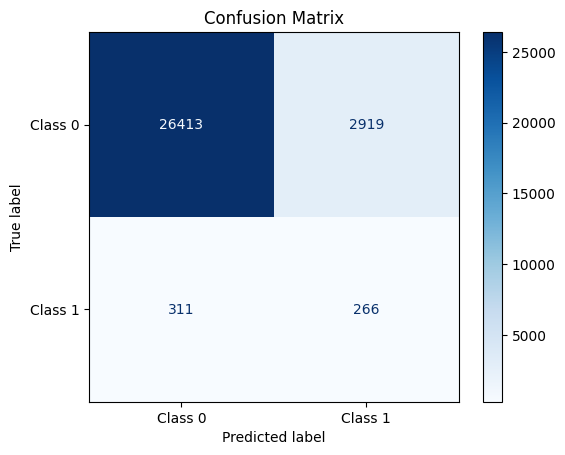

In [218]:
threshold = 0.2
y_pred = (y_proba_positive >= threshold).astype(int)

print('Classification Report:')
print(classification_report(y_train, y_pred))


conf_matrix = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)

При установлении кастомного порога для классификации модель способна различать положительный случаи гораздо лучше.

Так, при пороге классификации 0.2 уже каждый второй покупатель верно распознается моделью.
Однако достигается это ценой заметного увеличение ложно положительных результатов

Однако необходимо рассмотреть эти результаты с точки зрения бизнеса.

Верно распознанные покупатели является ядерными клиентами. 
Можно сказать, что эти клиенты предсказуемые и понятные в условиях бизнеса. Можно рассчитывать на их возвращение при сохранении текущих бизнес-процессов. 

Клиенты, которых не удалось распознать даже при снижении порога являются "черными ящиками". Без улучшения модели нет возможности понимать за счет чего они вернулись. В рамках дальнешего исследования это хорошие кандидаты в том числе для качественного исследования, которое могло бы дать идеи для улучшения модели, так и для того, какие данные необходимо собирать

Наиболее интересная группа - это ложноположительные клиенты. С одной стороны, такие клиенты не совершили покупок, несмотря на то, что модель оценила их как потенциальных покупателей. С другой стороны, это значит, что они обладают схожими характеристиками с теми людьми, которые покупки все-таки совершили.
Возможно, таких клиентов можно воспринимать как потенциальных клиентов - и сфокусироваться на привлечении именно этих клиентов и разработке предложений под них.


### <a id='toc1_7_2_'></a>[Показатели модели на Validation](#toc0_)

In [219]:
y_pred = final_pipeline.predict(X_val)
y_proba = final_pipeline.predict_proba(X_val)
y_proba_positive = final_pipeline.predict_proba(X_val)[:, 1]

AUC Score: 0.770

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.19      0.05      0.08       192

    accuracy                           0.98      9970
   macro avg       0.59      0.52      0.54      9970
weighted avg       0.97      0.98      0.97      9970



<Figure size 1000x800 with 0 Axes>

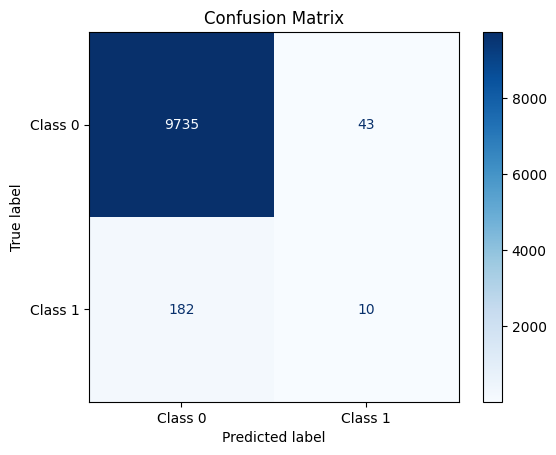

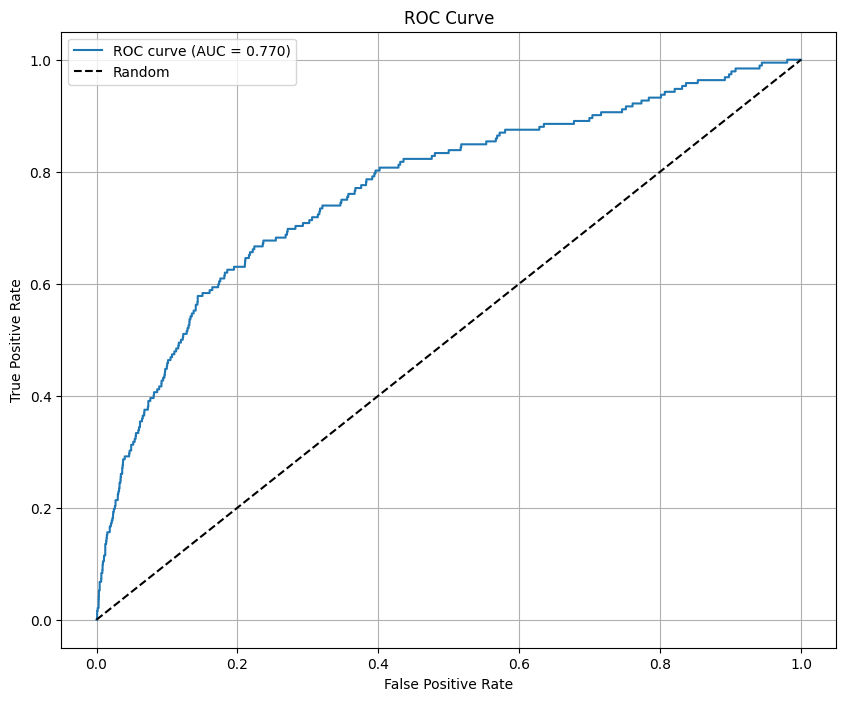

In [220]:

auc_score = roc_auc_score(y_val, y_proba_positive)
conf_matrix = confusion_matrix(y_val, y_pred)


print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_val, y_pred))


plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)


plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_val, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Работа модели на валидации почти идентична такой на тренировочной выборке. Оверфита не наблюдается

### <a id='toc1_7_3_'></a>[Показатели модели на Test](#toc0_)

In [221]:
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)
y_proba_positive = final_pipeline.predict_proba(X_test)[:, 1]

AUC Score: 0.760

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.18      0.04      0.07       192

    accuracy                           0.98      9970
   macro avg       0.58      0.52      0.53      9970
weighted avg       0.97      0.98      0.97      9970



<Figure size 1000x800 with 0 Axes>

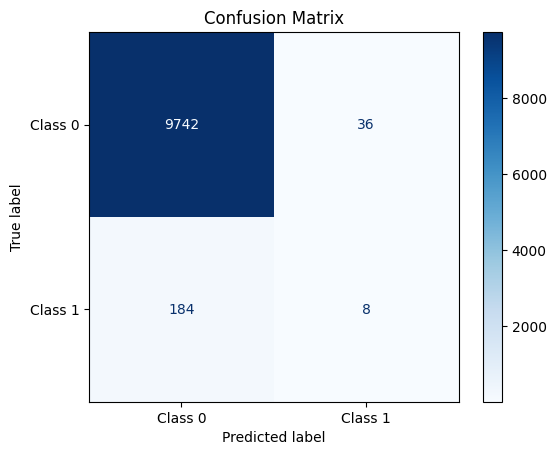

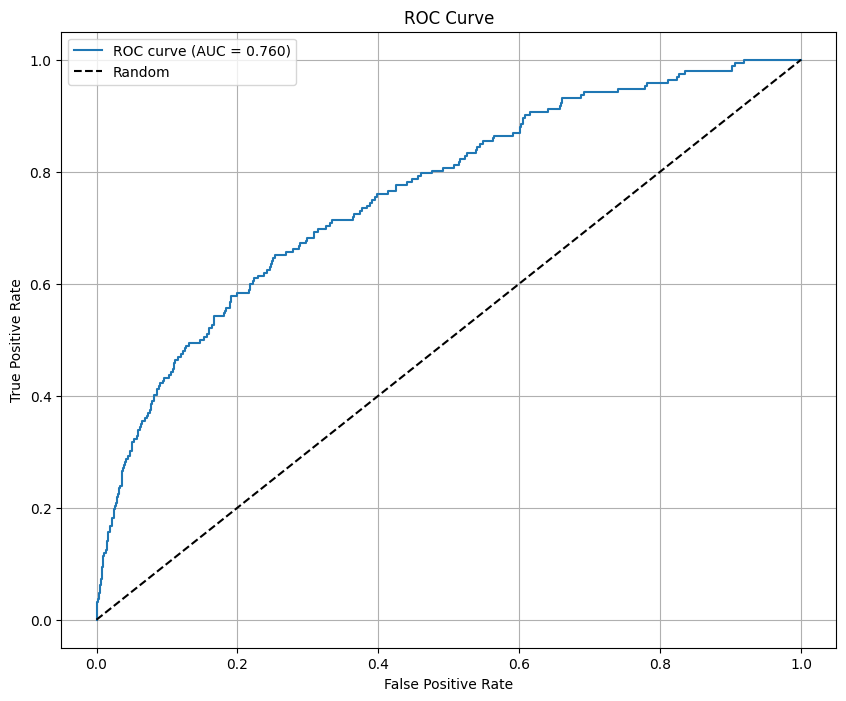

In [222]:

auc_score = roc_auc_score(y_test, y_proba_positive)
conf_matrix = confusion_matrix(y_test, y_pred)


print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_test, y_pred))


plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)


plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Итоговая метрика модели на тесте - 0.76